# Gradient Descent Constant step size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [15]:
#Defining function to generate Ybus, a voltage distribution for test bench and power crossponding to it 
#Generating Y buses and a test bench
def get_y(n, avg_conn, min_y, max_y):
    y_mat = np.zeros((n, n), dtype='complex128')
    for i in range(n):
        num_connections = min(np.random.poisson(avg_conn), n-1)
        connected_buses = np.random.choice([j for j in range(n) if j != i], size=num_connections, replace=False)

        y_mat[i, connected_buses] = (
            np.random.uniform(min_y, max_y, size=num_connections) -
            1j * np.random.uniform(min_y, max_y, size=num_connections)*2
        )
    y_mat = (y_mat + y_mat.T) / 2
    
    yy_mat = np.zeros((n, n), dtype='complex128')
    for i in range(n):
        for j in range(n):
            yy_mat[i][i] += y_mat[i][j]
            if(i!=j): yy_mat[i][j] = 0-y_mat[i][j]

    return yy_mat


def get_v(n, mag_high, mag_low, angle_high, angle_low):
    mag = np.random.rand(n, 1) * (mag_high - mag_low) + mag_low
    angles = np.random.rand(n, 1) * (angle_high - angle_low) + angle_low
    angles = np.deg2rad(angles)
    v = mag * np.exp(1j * angles)
    return v

def get_S(y, vr):
    S = vr*(np.conj(y)@np.conj(vr))
    
    return S

In [16]:
#Intializing the System with fixed number of buses and intial voltage distributation
N=2000

n = N+1 #Total number of buses
avg_conn = 12 #Average connection
min_y, max_y = 5, 10
mag_high, mag_low = 1.1, 0.9
angle_high, angle_low = 10, 0


y = get_y(n, avg_conn, min_y, max_y) #Generating Y bus
Ybus = y[1:,1:] #Excluding Reference bus

v = get_v(n, mag_high, mag_low, angle_high, angle_low) #Intial voltage distribution
v[0] = 1 #Setting Reference bus
V = v[1:]

s = get_S(y, v) #Power corrosponding to intial distribution 

In [17]:
#Intial guess
VR = np.ones((1,N),dtype='complex128') #Voltage Row vector
VC = np.reshape(VR,(N,1)) #Voltage column vector
Sref = get_S(Ybus,V) #Reference Power or Schadule power

ss = 0.05 #Step size
itr = 10 #Number of iteration
Error = [] #Error per iteration


t1=time.time()

for i in range(itr):

    J1 = VR.conj()*Ybus #Jacabian crossponding to voltage conjuctate
    J2P = np.reshape(Ybus@VC,(N))
    J2  = np.diag(J2P) #Jacabian croosponding to voltage 

    #power calculation
    Jreal = J1 +J2 #Real voltage Jacobian
    Jimg = 1j*J1 - 1J*J2 #Imag voltage jacobian
    S = get_S(Ybus,VC)    
    delS = Sref - S #Power correction
    
    delR = np.real((delS.T)@Jreal) #Gradient real part of voltage
    delI = np.real((delS.T)@Jimg) #Gradient img part of voltage
    
    delVR = delR/np.linalg.norm(delR) # Increment Real voltage(*)
    delVI = delI/np.linalg.norm(delI) #Increment imag voltage
    
    VR = VR+ss*(delVR+1j*delVI) #Change voltage
    VC = np.reshape(VR,(N,1))
    
    S = get_S(Ybus,VC) #Power crossponding to new voltage
    error2 = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
    Error.append(error2)
    
t2=time.time()
print(t2-t1)

8.07575798034668


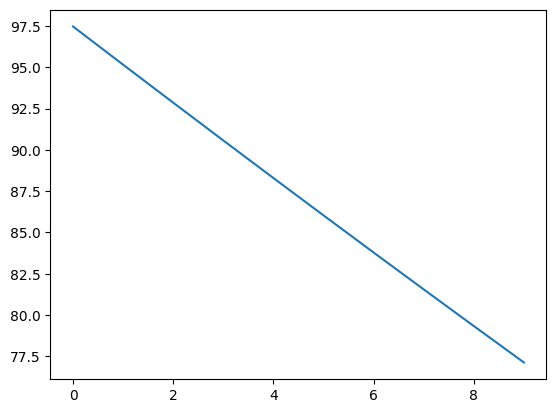

In [18]:
plt.plot(Error)

# Next we will vary the step size acoording to Error size

In [26]:
#Intial guess
VR = np.ones((1,N),dtype='complex128') #Voltage Row vector
VC = np.reshape(VR,(N,1)) #Voltage column vector
Sref = get_S(Ybus,V) #Reference Power or Schadule power
#intial error calucation
S = get_S(Ybus,VC) #Power crossponding to new voltage
error2 = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
err_slc = 12 #decide the scalling relation between error and step size
print(error2,err_slc)

ss = (0.1/err_slc)*error2 #Step size
itr = 10 #Number of iteration
Error = [] #Error per iteration




for i in range(itr):

    J1 = VR.conj()*Ybus #Jacabian crossponding to voltage conjuctate
    J2P = np.reshape(Ybus@VC,(N))
    J2  = np.diag(J2P) #Jacabian croosponding to voltage 

    #power calculation
    Jreal = J1 +J2 #Real voltage Jacobian
    Jimg = 1j*J1 - 1J*J2 #Imag voltage jacobian
    S = get_S(Ybus,VC)    
    delS = Sref - S #Power correction
    
    delR = np.real((delS.T)@Jreal) #Gradient real part of voltage
    delI = np.real((delS.T)@Jimg) #Gradient img part of voltage
    
    delVR = delR/np.linalg.norm(delR) # Increment Real voltage(*)
    delVI = delI/np.linalg.norm(delI) #Increment imag voltage
  
    VR = VR+ss*(delVR+1j*delVI) #Change voltage
    VC = np.reshape(VR,(N,1))

    S = get_S(Ybus,VC) #Power crossponding to new voltage
    error2 = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
    print(error2)
    ss = (0.1/err_slc)*error2
    Error.append(error2)

99.80551880142454 12
63.65965540066687
43.38797638610118
31.049575718592397
23.005689439865023
17.49655377670489
13.595262501396112
10.783588151201956
8.855087246879558
7.54432678295846
6.294955347292502


In [20]:
print(Error)

[59.56812897802102, 48.66210361325887, 41.09278586543951, 37.44130593892862, 33.97232175257582, 31.309741428299102, 28.992543949347972, 27.048650804465222, 25.001653858312434, 23.743209560937704]


In [221]:
print(Error)

[49.26665392576197, 29.91011637726733, 19.64744457576277, 15.939299724202424, 11.963853196873266]


In [222]:
def Rantree(VR,scale):
    tt=20
    AA = scale*(0.75+0.5*np.random.rand(tt))
    RR = np.zeros(tt)
    for i in range(tt):
        ss=AA[i]
        VR = VR+ss*(delVR+1j*delVI) #Change voltage
        VC = np.reshape(VR,(N,1))
        S = get_S(Ybus,VC)
        RR[i] = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
    
    index = np.argmin(RR)
    return AA[index]

In [73]:
def Gridtree(VR,scale,j):
    tt=20
    AA = np.linspace(0,scale,tt)
    #print(AA)
    RR = np.zeros(tt)
    for i in range(tt):
        xx=AA[i]
        VR = VR+xx*(delVR+1j*delVI) #Change voltage
        VC = np.reshape(VR,(N,1))
        S = get_S(Ybus,VC)
        RR[i] = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
    print(RR)
    GG[j]=RR

In [74]:
#Intial guess
VR = np.ones((1,N),dtype='complex128') #Voltage Row vector
VC = np.reshape(VR,(N,1)) #Voltage column vector
Sref = get_S(Ybus,V) #Reference Power or Schadule power
#intial error calucation
S = get_S(Ybus,VC) #Power crossponding to new voltage
error2 = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
err_slc = 8 #decide the scalling relation between error and step size
print(error2,err_slc)

ss = (0.1/err_slc)*error2 #Step size
itr = 20 #Number of iteration
Error = [] #Error per iteration
GG= np.zeros((10,20))
XX=0*VR
YY=0*VR

t1=time.time()

for i in range(itr):

    J1 = VR.conj()*Ybus #Jacabian crossponding to voltage conjuctate
    J2P = np.reshape(Ybus@VC,(N))
    J2  = np.diag(J2P) #Jacabian croosponding to voltage 

    #power calculation
    Jreal = J1 +J2 #Real voltage Jacobian
    Jimg = 1j*J1 - 1J*J2 #Imag voltage jacobian
    S = get_S(Ybus,VC)    
    delS = Sref - S #Power correction
    delR = np.real((delS.T)@Jreal) #Gradient real part of voltage
    delI = np.real((delS.T)@Jimg) #Gradient img part of voltage
    delVR = delR/np.linalg.norm(delR) # Increment Real voltage(*)
    delVI = delI/np.linalg.norm(delI) #Increment imag voltage
    Gridtree(VR,ss,i)
    VR = VR+ss*(delVR+1j*delVI) #Change voltage
    VC = np.reshape(VR,(N,1))

    S = get_S(Ybus,VC) #Power crossponding to new voltage
    error2 = 100*np.linalg.norm(Sref-S)/np.linalg.norm(Sref) #Error in Power
    #print("errror")
    print(error2)
    #print(ss/error2)
    ss = (0.1/(err_slc*((1.05)**i)))*((error2/100)**1)*100
    Error.append(error2)

t2=time.time()
print(t2-t1)

99.80551880142454 8
[ 99.8055188   96.75266908  90.71650165  81.87552409  70.6408692
  58.02805546  46.78714572  43.51660753  54.93217812  78.8468621
 110.90536755 149.2427416  193.40003815 243.51596512 300.0370716
 363.61463172 435.06406851 515.3461909  605.55604369 706.91416657]
49.877961341709764
[ 49.87796134  48.65191078  46.23483003  42.71161957  38.25815212
  33.24241994  28.46341617  25.56831534  26.90959019  33.53107896
  44.42478817  58.39003435  74.77163476  93.28495159 113.83357221
 136.42103111 161.11200506 188.0150972  217.2750523  249.0692154 ]
29.866563288697048
[ 29.86656329  29.23127436  27.99530454  26.24280571  24.14551228
  22.04050916  20.55166284  20.63238946  23.19812541  28.53487767
  36.3886413   46.45918056  58.60425627  72.82813806  89.23658951
 108.00568512 129.36402491 153.58268552 180.96920019 211.86362091]
20.901922771412774
[ 20.90192277  20.43238624  19.55688306  18.41597165  17.25380314
  16.44438631  16.46097743  17.71119277  20.33330174  24.20938467

IndexError: index 10 is out of bounds for axis 0 with size 10

In [68]:
print(Error)

[49.877961341709764, 29.866563288697048, 20.901922771412774, 16.33792189258394, 12.772486834915322, 10.599986419095538, 8.643047923828375, 7.3049937367239455, 6.142586594289129, 5.27105322643561, 4.525293157566552, 3.9339691470022373, 3.4305324822310252, 3.017340053848214, 2.6654105181837076, 2.370509015580937, 2.1186891414641775, 1.9051253411076043, 1.7221890442524599, 1.5658765025531594]
